<a href="https://colab.research.google.com/github/misakinogi/seminar-/blob/main/SSES%E7%AC%AC7%E5%9B%9E%E6%95%99%E6%9D%90_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境シミュレーション実習
このドキュメントは、早稲田大学人間科学部「環境シミュレーション実習（Simulation Studies for Environmental Sciences）」用の教材であり、正規受講者に限り利用ができます。環境科学研究でよく用いられる基本処理を初学者が効率よく勉強していくために開発されたオリジナル教材です。この教材の本実習授業以外への転載は必ず相談してください（太田俊二: shun@waseda.jp）。

## 第7回 シミュレーションモデルを体感する－メタ個体群動態モデルを使って ##

* 今回の目標（シミュレーションモデルにおける初期値の意味を理解する、エージェントベースモデルの基本を知る、初期値を確率的に操作する、計算の時間ステップの意味を知り、空間モデルに実装する）
* 今回の実習の流れ（モデルのパラメータに初期値を与える、エージェントベースモデルの基本を知り、視覚化も行う、初期値を確率的に与える、初期値を偏った確率で設定する、空間を記述したモデルを時間発展させる）

前回の実習では、シミュレーションに必要なパーツや小物を準備してきました。8方向のなかに特定の数値を持つコマが何コマあるかを数えるというもので、その解決のためには**アルゴリズム**や**データ構造**に着目する必要がありました。今週もパーツづくりを引き続きやっていきますが、確率的なシミュレーションの基本、偏った確率の初期値によって生物の在・不在をシミュレーションする方法、空間規模のモデルを時間発展させる記述法を習得していきます。

ここで取り扱うモデルは、主体に対して入力と出力の項があり、それぞれの値が時間的に変化するタイプのものである。具体的には、主体が個体群、入力は移入・誕生、出力は移出・死亡である。

SystemApproach.svg

**図. 個体群動態モデルの基本的な考えかた**　メタ個体群とは、同種の生物の集まりである個体群同士がさらに大きな集まりとして捉えられるもの、と理解してほしい（ここでは生態学的な定義等の説明は馴染まないので避けたい。おおまかな理解で十分である）。

### 7–1. モデルの性質を決めるパラメータに初期値を与える

時間発展型のモデルを動かすための必須項目は**初期値**です。一般に、モデルを動かすにはデータが必要であるとと思われがちですが、正しくは初期値（のデータ）です。初期値を与えない限り、モデルは動きませんが、反対に初期値さえ与えてあげれば、あとは勝手に計算を続けるものです。

研究室ではただ一言、「パラメータを決めてください」と言われます。どういう意味でしょうか。もう少し砕いて言うと**「パラメータを設定し、その初期の値として何を指定するかを決めてください」**という意味です。

たとえば、以下のようなものです。今回実習で使うメタ個体群動態モデルでは、周囲の仲間の数を基準にして2つないしは3つのグループに分けてシミュレーションします。移入の確率（$P_i$）と移出の確率（$P_e$）をそれぞれ0〜1の範囲で与えます。前者のパラメータは生物の個体の増えやすさを意味しているので、仲間の数が多いグループほど高い値を設定します。反対に、後者は減りやすさを意味しているので、仲間の数が多いほど低い値を設定します。



8neighbors.svg

**図. 個体群規模が拡大する場合と縮小する場合の基本的な考えかた**　主体からみた8方向のうち、同種の仲間がたくさんいるほど個体群規模は拡大しやすく、反対に少ないと縮小しやすくなる。この様子を定量的に表現するためのパラメータが移入確率（$P_i$）と移出確率（$P_e$）である。確率というと、完全なランダムを想起しやすいが、それぞれの**パラメータ値の大きさによって確率に偏りを生じさせる**ことがポイントである。

まずは、周囲に存在する仲間の数にしたがって、2つのグループに分ける場合を考えてみます。

In [ ]:
# 仲間の数の最大値は8（＝8方向), 仲間の数が多いほど移入や生殖には有利に働く（仲間の数でグループ分けをする）
llnum_group1 = 0 # 仲間の数の下限 Lower limit number of members (Group1)
llnum_group2 = 4 # 仲間の数の下限 Lower limit number of members (Group2)
# Pi
Pi1 = 0.20 # Pi = probability of colonization, 移入の確率 0-1
Pi2 = 0.40 # 移入・誕生の確率が大きくなるほど「仲間」は増えやすくなる。
# Pe
Pe1 = 0.45 # Pe = probability of local extinction, 移出の確率 0-1
Pe2 = 0.25 # 移出・死亡（消滅）の確率が大きくなるほど「仲間」は減りやすくなる。

仲間の数を意味する変数として、``state_number`` を計算してきました（6–4節）。ここでは単純化のため、前回の``state_number`` を求めるプログラムと統合して部品をつくるのではなく、プログラム内で手動で与えるやり方で移入の確率（$P_i$）と移出の確率（$P_e$）を決めていくことにします。


In [ ]:
state_number = 6

#   周りの状況からPi: 移入確率（0–1）、Pe: 移出確率（0–1）を設定する  ##
if state_number < llnum_group2:   # if state_number >= llnum_group1 and state_number < llnum_group2:
    Pi = Pi1
    Pe = Pe1
else:                       #elif state_number >= llnum_group2:
    Pi = Pi2
    Pe = Pe2

print(Pi, Pe)

0.4 0.25


仲間の数にしたがって3つのグループに分けてそれぞれに初期値が与えられている場合に移入の確率（$P_i$）と移出の確率（$P_e$）を決めるにはどのようなコードになるでしょうか。

In [ ]:
# 仲間の数の最大値は8（＝8方向), 仲間の数が多いほど移入や生殖には有利に働く（仲間の数でグループ分けをする）
llnum_group1 = 0 # 仲間の数の下限 Lower limit number of members (Group1)
llnum_group2 = 3 # 仲間の数の下限 Lower limit number of members (Group2)
llnum_group3 = 5 # 仲間の数の下限 Lower limit number of members (Group3)
# Pi
Pi1 = 0.15 # Pi = probability of colonization, 移入の確率 0-1
Pi2 = 0.30 # 移入・誕生の確率が大きくなるほど「仲間」は増えやすくなる。
Pi3 = 0.45
# Pe
Pe1 = 0.45 # Pe = probability of local extinction, 移出の確率 0-1
Pe2 = 0.30 # 移出・死亡（消滅）の確率が大きくなるほど「仲間」は減りやすくなる。
Pe3 = 0.20

In [ ]:
# 以下のコードを完成させて、state_number のときのPi, Pe が選択されているか確かめてください。

state_number = 6

#   周りの状況からPi: 移入確率（0–1）、Pe: 移出確率（0–1）を設定する  ##
if state_number<3:
    Pi = Pi1
    Pe = Pe1

elif   state_number<5:
    Pi = Pi2
    Pe = Pe2

else:
    Pi = Pi3
    Pe = Pe3

print(Pi, Pe)

0.45 0.2


InitialValue.svg

**図. 時間発展型のシミュレーションモデルのイメージ**　例をあげて説明しよう。個体群$N$の大きさが緑色の比例関係（$r$の値は一定）にあるとき、左の図のままでは計算ができない。右の図のように、時刻$t$ = 0 のときの個体群の大きさ $ N_0 $ の値を初期値として与えると、初めて$N_{t+1}$の大きさが計算される。あとは人間が何もしなくても、勝手に次の時間の$N_{t+2}$、$N_{t+3}$・・・と緑色の掛け算をタイムステップごとに繰り返し計算していく。

### 7–2. 乱数を使って確率的なシミュレーションを行う

コンピュータはさまざまな乱数を発生させることができます。ここでは、統計学的な乱数（擬似乱数）についての深い議論は避け、単純なものに限定して話を進めます。

#### 7–2–1. 確率的に動くエージェントを記述する

エージェントとはコンピュータ上を自在に動く主体であると考えてください。それは、水、土壌や植物、動物でも人間でも構いません。プログラム（コード）上ではすべて同じです。**同じプログラムにどのような意味を持たせるか**が重要なのです。逆に言うと、特定の学問分野に特化したプログラム（コード）はないということです。この項では有名な**ランダムウォーク**をテーマにして、**エージェントモデル**を体験してみます。ランダムウォークは酔っ払いがどのように歩くか予想がつかない様子に喩えられることもあります。毎回歩いていく先が確率的に変わるという特徴があるということです。

この項では、ランダムウォークの様子のグラフを描き、**試行のたびに結果が変わる**ということを目で見て実感してみます。

シンプルなランダムウォークのモデルを、以下の条件を満たすように記述していきます。
*   エージェントの数は1とします。
*   エージェントの初期位置のy座標（location_y）とx座標（location_x）はランダムに決まり、y, x 座標それぞれの範囲は0〜10とします。
*   エージェントは、初期位置から4ステップ移動するとし、1回のステップで移動する範囲は–2〜2とします。



In [ ]:
# 乱数の使い方（試行のたびに結果が変わることを確認してください）

import random

test_dice = random.random()                 # 乱数を発生させたら、変数に格納するのが一般的である（結果を固定できるため）
test_dice10 = random.random() * 10          # random.random() で 0-1, 10倍すれば、0-10の範囲の乱数を発生させることになる

print(test_dice)
print(test_dice10)

0.8097434811205177
0.30363799320454854


``random``モジュールの``random``を引数なしで使うと、0〜1の乱数を返しますので、これを使って、初期位置のy座標（init_location_y）とx座標（init_location_x）に代入します。初期座標を0番地の値とするy座標のリスト（yList）とx座標のリスト（xList）それぞれを作成します。その座標から確率的にy座標（location_y）・x座標（location_x）を移動し、そのステップが4回繰り返されます。なお、**乱数を発生させたら、変数に格納する**ことが多く、以降はその変数を使って計算を進めます（計算式のなかで直接乱数を発生させることはしません）。

In [ ]:
import random

step = 4                                    # 移動するステップ数

init_location_y = random.random() * 10
init_location_x = random.random() * 10
location_y = init_location_y
location_x = init_location_x
yList = [location_y]                        # yListというリストを location_y という値で初期化・作成している
xList = [location_x]                        # xListというリストを location_x という値で初期化・作成している

for i in range(step):
    location_y += (random.random() - 0.5) * 4   # この2行の意味（何をしているか）を日本語で説明する
    location_x += (random.random() - 0.5) * 4
    yList.append(location_y)
    xList.append(location_x)

print(yList, xList)

[2.93475436126599, 3.525702615760486, 4.172302808502412, 5.941591432384384, 4.280573341989211] [0.3035466484312166, -0.3771712962343434, 0.029396261000593782, 0.34758563880626214, -1.3978730143541402]


上のように yList, xList とも、初期値＋ステップ数4で合計5個の座標データが収納されることになります。


SHUTAI moves.svg

**図. 時間的に変化する事象をモデル化する際に必要な二段階の仮定** 何かのモデルを作成する際、まず最初に主体を仮定しなければならない。ただし、主体とは○○のことである、という記述はプログラム上で記載することはほとんどない。仮定した主体がどのような**動き**をするかで主体の特徴を記述する。

##### ■オンデマンド演習課題 1

エージェントが前の段階の位置から-4〜+4の範囲で移動するように書き換えてください。以下の新しいコードセルに解答してください。

In [ ]:
# 書き換えたコードを記してください。

import random

step = 8                                # 移動するステップ数

init_location_y = random.random() * 10
init_location_x = random.random() * 10
location_y = init_location_y
location_x = init_location_x
yList = [location_y]                        # yListというリストを location_y という値で初期化・作成している
xList = [location_x]                        # xListというリストを location_x という値で初期化・作成している

for i in range(step):
    location_y += (random.random() - 0.5) * 8   # この2行の意味（何をしているか）を日本語で説明する
    location_x += (random.random() - 0.5) * 8

    yList.append(location_y)
    xList.append(location_x)

print(yList, xList)


[7.591340320833794, 9.505188161497811, 9.971124839565256, 10.765228605049657, 9.575839562311419, 11.236529367481285, 10.941674259973325, 9.484960223302842, 7.595278452441583] [9.302616521366899, 10.37040896098415, 8.462904373939502, 6.526383557797555, 4.855470315418117, 6.261185511524841, 4.792691050627937, 2.987173847478171, 3.08914552915721]



それでは次に、エージェント数を1ではなく、3に増やしてみましょう。

In [ ]:
import random

agent_num = 3                               # エージェント数
step = 4                                    # 移動するステップ数

for n in range(agent_num):
    init_location_y = random.random() * 10
    init_location_x = random.random() * 10
    location_y = init_location_y
    location_x = init_location_x
    yList = [location_y]
    xList = [location_x]

    for i in range(step):
        location_y += (random.random() - 0.5) * 4
        location_x += (random.random() - 0.5) * 4
        yList.append(location_y)
        xList.append(location_x)

    print(yList, xList)

[3.308036765907506, 2.555661676154566, 3.8045852216852896, 5.551938446368801, 4.5785070265968235] [2.984744932506965, 3.862935706910811, 2.4290860924737614, 3.6734293912105693, 4.885523495646289]
[6.969541983694457, 5.864508204552524, 3.8709040275594697, 2.735017149962678, 3.7370279107965967] [7.540946119600917, 6.88203134739355, 5.35931369629677, 6.505497710308143, 7.835990850575378]
[0.9784872765838215, -0.8299802897015209, -2.1542415959181653, -1.2241397437867652, -0.6102808980361947] [5.8005377085969325, 6.664600621257451, 8.065815349011388, 6.370973172162877, 8.256065048622574]


step数の外側にループをつくり、エージェント数分だけ繰り返せばよいわけです。

次に、各エージェントがどのよう移動しているか**軌跡**を描いてみましょう。上記のリストyList, xList を matplotlib の pyplot に引き渡すだけです。

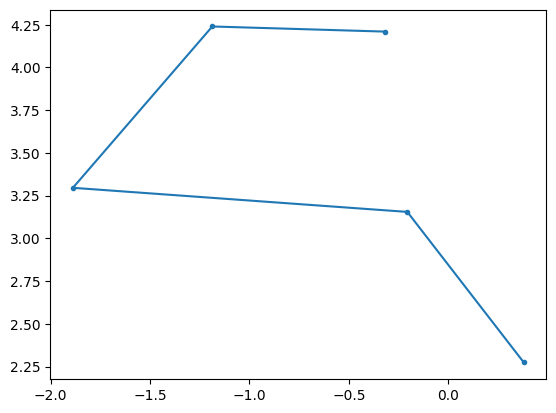

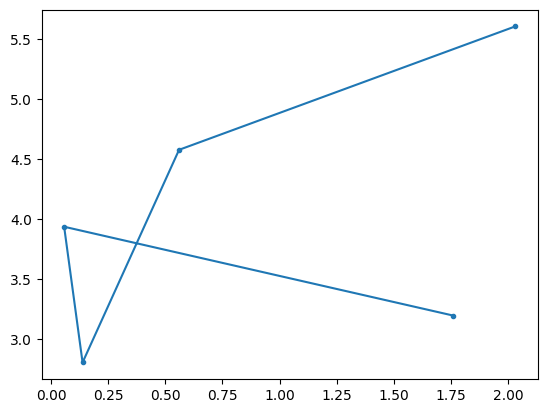

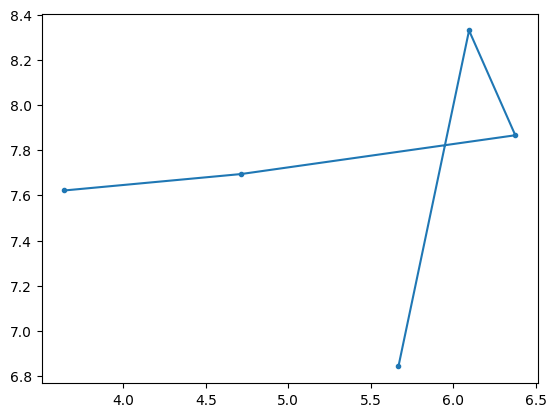

In [ ]:
import random
import matplotlib.pyplot as plt

agent_num = 3                               # エージェント数
step = 4                                    # 移動するステップ数

for n in range(agent_num):
    init_location_y = random.random() * 10
    init_location_x = random.random() * 10
    location_y = init_location_y
    location_x = init_location_x
    yList = [location_y]
    xList = [location_x]

    for i in range(step):
        location_y += (random.random() - 0.5) * 4
        location_x += (random.random() - 0.5) * 4
        yList.append(location_y)
        xList.append(location_x)

#    print(yList, xList)
    plt.plot(yList, xList, marker='.')      # marker='o'        # pyplot の基本は描画したいデータをリスト形式で引き渡すだけである
    plt.show()

エージェント数が増えるとグラフの数も増え、視認性が悪くなります。複数のエージェントの動きを一度に描画する（一つのグラフにまとめる）にはどうすればよいでしょうか。

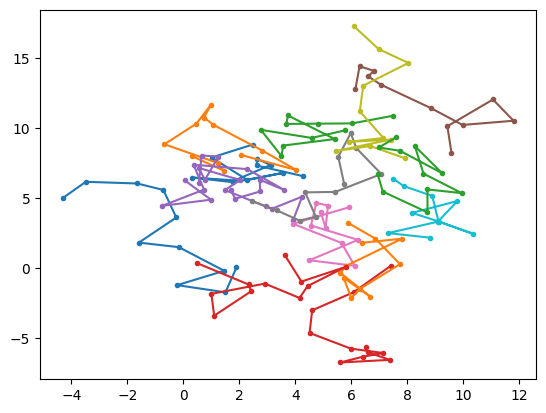

In [ ]:
import random
import matplotlib.pyplot as plt

agent_num = 15                                  # エージェント数
step = 10                                       # 移動するステップ数

for n in range(agent_num):
    init_location_y = random.random() * 10
    init_location_x = random.random() * 10
    location_y = init_location_y
    location_x = init_location_x
    yList = [location_y]
    xList = [location_x]

    for i in range(step):
        location_y += (random.random() - 0.5) * 4
        location_x += (random.random() - 0.5) * 4
        yList.append(location_y)
        xList.append(location_x)

    plt.plot(xList, yList, marker='.')  # デフォルトで勝手に色がつく
plt.show()

なお、上記のような書き方ではなく、**オブジェクト指向型のプログラミング**をする方がPythonの場合には都合がよいと言われています。それは、メンテナンス性に優れ、複数人で開発や運用にあたるコードの場合にはオブジェクト指向の方が有利だからです。とはいえ、この実習授業では、システム開発やプログラムの高速化を守備範囲とはしていませんので、オブジェクト指向の記述法ではなく、**手続きを順に記述していくスタイル**で今後も進めていきます。

#### Box 7: matplotlib での描画に少しだけこだわる

**（1）複数のグラフは比較してこそ意味がある**

上記の単体のエージェントが動くグラフを比較したいとき、デフォルトの出力のままでは困難（一目でわからない）です。グラフ同士を比較するためには、グラフの軸の幅を合わせることが必須です（グラフのサイズを合わせるだけでは軸の間隔が変わる場合もあるので比較できません）。また、適切にタイトルを付与する（主として計算条件の違いを明示する）必要もあります。

pyplot のニックネームを plt とした場合、``plt.ylim(最小値,最大値)``, ``plt.xlim(最小値,最大値)``で軸の下限と上限を指定できます。これを複数のグラフに同様の数値を指定することにより、グラフ間で軸を統一させることができ、グラフ間比較が容易になります。

**（2）タイトルや軸の説明を加える**

pyplotのそのほかのオプションとして、``plt.title('タイトル')``, ``plt.ylabel('y軸の説明')``, ``plt.xlabel('x軸の説明')``があり、それぞれタイトルやy軸、x軸の説明を加えることができます。なお、現時点では、標準のmatplotlibでは日本語を扱うことができませんので、注意してください（ライブラリの導入で利用可能になるものの、副作用があります）。


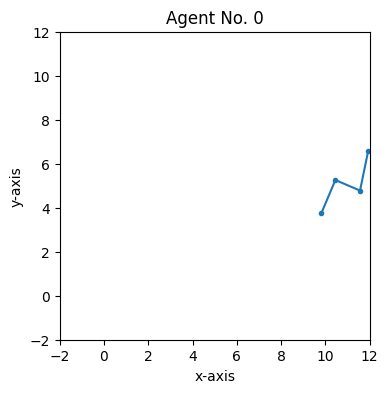

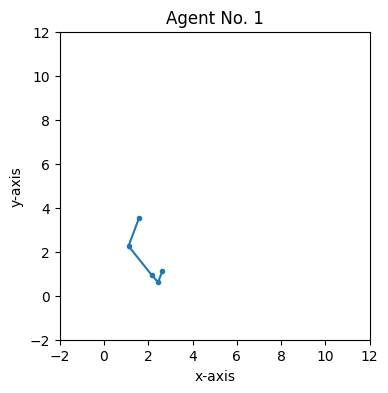

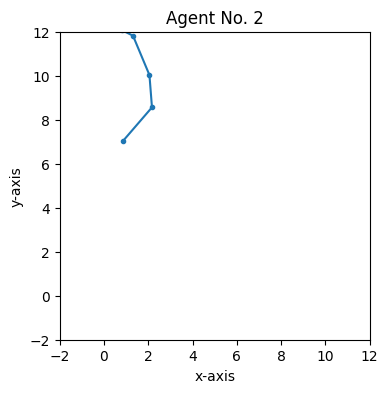

In [ ]:
import random
import matplotlib.pyplot as plt

agent_num = 3                               # エージェント数
step = 4                                    # 移動するステップ数

for n in range(agent_num):
    init_location_y = random.random() * 10
    init_location_x = random.random() * 10
    location_y = init_location_y
    location_x = init_location_x
    yList = [location_y]
    xList = [location_x]

    for i in range(step):
        location_y += (random.random() - 0.5) * 4
        location_x += (random.random() - 0.5) * 4
        yList.append(location_y)
        xList.append(location_x)

#    print(yList, xList)
    plt.figure(figsize=(4, 4))                                  # 最初（plotする前）に描画サイズを決める
    plt.plot(yList, xList, marker='.')      # marker='o'        # pyplot の基本は描画したいデータをリスト形式で引き渡すだけである
    plt.title('Agent No. {}'.format(n))                         # 各グラフに Agent No. を入れる（メタ個体群モデルでも活用している）
    #plt.title('Agent No.%d' % (n))
    plt.ylim(-2,12)                                             # ylim(最小値,最大値)
    plt.xlim(-2,12)                                             # xlim(最小値,最大値)
    plt.ylabel('y-axis')
    plt.xlabel('x-axis')
    plt.savefig('test-figure{}.png'.format(n))                  # test-figure.png とすると、最後のグラフだけが出力されてしまう
    #plt.savefig('test-figure{}.png'.format(n), dpi = 150)       # dpi オブションで解像度を指定できる
    #plt.savefig('test-figure{}.svg'.format(n))                  # svg はベクター型のファイルであるので、dpiオプションは使えない（不要）が、描画は非常にきれいである。
    plt.show()


``title``はグラフの一般的なキャプション（多くの分野の科学論文では図の下にキャプションを入れます）というよりは、上記のようにそのグラフのステイタス（この例では、何番のエージェントか、など）を記すために用いることが多いです。その際、タイトルのなかのテキストを変数化したいということが多くなります。今回の例では Agent_num は n で回っていますから、

1.   ``plt.title('Agent No.{}'.format(n))``
2.   ``plt.title('Agent No. %d' % (n))``  # cの形式

などとすると実現できます。この実習ではどちらでもよいですが、Cをやっていない人は1番のやり方でよいでしょう。

**（3）グラフをファイルに保存する**

数値実験をした直後の出力結果をざっと眺めるだけでなく、一度ファイルに保存して後からじっくりと眺めてみるということも悪いことではないです。また、リポートを書く場合でも見やすいグラフで結果を示すことが大切です。matplotlibで描画したグラフの保存は、``plt.savefig(保存先のディレクトリ名/ファイル名)``とするだけです。

ファイルのフォーマットは指定するファイル名の拡張子*により自動判別されます（``format``により明示することも可能ですが、混乱する場合もあるので不要でしょう）。また、ラスター形式のファイルを指定する場合では、dpiオプションにより解像度を手動で指定できます。

```
*保存できるファイルフォーマット（emf, eps, jpeg, jpg, pdf, png, ps, raw, rgba, svg, svgz, tif, tiff）
```

なお、``title``と同様に、ファイル名を自動的に連番にするなどしたい場合には、先の``format``関数を使って実現することができます。

#### 7–2–2. 確率的に在・不在を決めるパーツをつくる

前項7–2–1で得たやり方（``random.random``）を応用して、在・不在を更新するプログラムをつくってみましょう。具体的には個体の状態を表す変数 state を置き、当該年の在・不在を更新します。ただし、前項のランダムウォークとは異なり、**完全に偶然によって決まるということではない**ことに注意が必要です。7–1で与えるパラメータによって状況が変わり、それに応じてチャンスレヴェルが変わる（偏る）ということです。

**開発の手順（1）** いきなり本番のデータでプログラムを開発するのではなく、6−4で扱った在・不在のミニデータを使うとよいでしょう。また、二次元リストの要素のすべてを調べるのではなく、二次元リストの``(y,x) = (2,3)``を主体（中心、自分）とすることで、在・不在の決定のルーチンに絞って開発することができます（主体を入れ替えながら調べる必要がなくなる）。加えて、7–1で扱った初期値（$P_i$ と $P_e$）もあえて決め打ちする（直接与える）とよいです。<u>本来は変動する値ですが、それらをあえて固定する</u>ことによって、開発すべきプログラムのポイントを絞って検討ができ、楽になります。

初期値として与える$P_i$ と $P_e$ の値と乱数を発生させた値の二つを使って、在・不在を1個体ずつ決めていきます。

---
今回のモデルの在・不在のルール
*   もしパッチに生物が存在しているとき、$P_e$ という確率で生物は消滅する
*   もしパッチに生物が存在していない＋周囲に仲間がいるとき、$P_i$ という確率で生物は移入する
*   もしパッチに生物が存在していない＋周囲に仲間がまったくいないとき、生物は存在できない

$P_e$ と発生させた乱数の関係は以下のとおりです。
```
0------------------------------0.5------------------------------1.0
××××××××                                                   消滅確率 0.25 のとき、乱数が0〜0.25で不在となる
××××××××××××××××                                   消滅確率 0.50 のとき、乱数が0〜0.50で不在となる
×××××××××××××××××××××××××                 消滅確率 0.75 のとき、乱数が0〜0.75で不在となる
```
$P_i$ についても上記と同様で、「不在（`×`）」が「在（`○`）」になるだけです。
```
0------------------------------0.5------------------------------1.0
○○○○○○○○                                                   移入確率 0.25 のとき、乱数が0〜0.25で在となる
○○○○○○○○○○○○○○○○                                   移入確率 0.50 のとき、乱数が0〜0.50で在となる
○○○○○○○○○○○○○○○○○○○○○○○○○                 移入確率 0.75 のとき、乱数が0〜0.75で在となる
```


それでは、ミニデータとstate_number（8方向中の仲間の数）の値を調整しながらテストします。

In [ ]:
#（1）6−4の初期分布図のデータを Copy & Paste、（2）state_numberを変えて結果の違いを確かめる（3）初期分布図の1の場所を適当に変えて違いを確かめる。

import random

Pi = 0.3
Pe = 0.3
state_number = 8

### 初期分布図（6列5行）1: 在パッチ、0: 不在パッチ              # 6-4のコードから Copy & Paste
distribution = [
                [0,2,0,0,2,0],
                [0,0,1,1,1,0],
                [0,0,1,0,1,0],
                [0,0,1,1,1,0],
                [0,2,0,0,0,0]
                ]

y = 2; x = 3    # 中心（自分自身）パッチの番地（3行目4列目）

if distribution[y][x] == 1:                                     # もしパッチに個体群がいたら
    Pe_rand = random.random()                                   #--- 乱数でPe（移出・死亡（消滅）の確率）を得る
    if Pe_rand < Pe:                                            #--- もし乱数の値より与えられたPeの値の方が大きければ（初期のPeの値の範囲内であれば）
        state = 0                                               #------- 生物はいなくなる（state = 0）
    else:                                                       #--- それ以外→生物はそのまま存在する（state = 1）
        state = 1
if distribution[y][x] == 0 and state_number > 0:                # もしパッチに個体群がいない＋周囲に仲間がいたら
    Pi_rand = random.random()                                   #--- 乱数で Pi（移入・誕生の確率）を得る
    if Pi_rand < Pi:                                            #--- もし乱数の値より与えられたPiの値の方が大きければ（初期のPiの値の範囲内であれば）
        state = 1                                               #------- 生物が移入・誕生する（state = 1）
    else:                                                       #--- それ以外→生物はいなくなる（state = 0）
        state = 0
if distribution[y][x] == 0 and state_number == 0:               # もしパッチに個体群がいない＋周囲に仲間がまったくいなかったら
    state = 0                                                   #------- 生物はいなくなる（state = 0）

print(state)

0


##### ■オンデマンド演習課題 2

state_number の値を変えて数回実行してください。また、3行目4列目付近の初期分布に在パッチを増やして数回実行してください。なお、結果やコードがわかるように工夫してください。上記の教材のパラメータ値から自分で変えた値によってどんな結果になったかを簡潔にまとめ、各パラメータがどんな役割を果たしているかを日本語で記してください。

以下に日本語で記してください。

----
ステイトナンバーを増やしていくにつれて、生物がいなくなる確率が高まり、減らしていくにつれて存在する確率が上がる。

 また、周りに生物がいるほど、存在する確率が上がった

**開発の手順（2）** （1）でつくったコードをもとにして、主体（中心、自分）を固定するのではなく、ミニデータの初期分布図を読み込んだ二次元リスト（distribution）の ` (y, x) = (0, 0) ` から順に次々と変化させながら（主体が変わる）すべての値の場合について調べていきましょう。

In [ ]:
# 出力結果が見やすくなるようにコードを完成させてください。

import random

Pi = 0.3
Pe = 0.3
state_number = 4    # この値を変えながら挙動を確かめる

### 初期分布図（6列5行）1: 在パッチ、0: 不在パッチ               # 6-4のコードから Copy & Paste
distribution = [
                [0,0,0,0,0,0],
                [0,0,1,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]
                ]

############### 行数、列数をカウント ###############
maximum_y = len(distribution)       # 行数（第4〜5回で実習した内容）
maximum_x = len(distribution[0])    # 列数

# 変数の初期化 ###############################################
state = 0 # 個体の状態を表す変数、1は存在、0は不在を示す

# パラメータの初期値と比較して、当該年の在・不在を決定する（メイン）###      # 確率的に新しい在・不在の分布図（マップ）をつくるということ。ただし、前項のランダムウォークと違い、完全な偶然ではない（パラメータ）。
for y in range(maximum_y):
    for x in range(maximum_x):
        if distribution[y][x] == 1:                               #
            Pe_rand = random.random()                             #--- 乱数でPe（移出・死亡（消滅）の確率）を得る
            if Pe_rand < Pe:                                      #---
                state = 0
            else:
                state = 1
        if distribution[y][x] == 0 and state_number > 0:          # もしパッチに個体群がいない＋周囲に仲間がいたら
            Pi_rand = random.random()                             #--- 乱数で Pi（移入・誕生の確率）を得る
            if Pi_rand < Pi:                                      #---
                state = 1
            else:
                state = 0
        if distribution[y][x] == 0 and state_number == 0:
            state = 0

        print(state,end="/t")
    print("")

                 # タブで見やすくしたのみ
                                # 改行で見やすくしたのみ変更


0/t1/t0/t0/t1/t1/t
0/t0/t1/t1/t0/t1/t
0/t0/t0/t0/t0/t0/t
1/t1/t0/t0/t1/t0/t
0/t0/t1/t0/t0/t0/t


**開発の手順（3）** 上記のように、都度計算したstateの値をただそのままprintするだけでは使いものになりません。計算結果を一時的に保存しておく必要があります。保存するには、逐次ファイルに書き込む方法とリストに格納する方法があります。同じプログラム内で利用することを考えると、すぐに取り出しやすいリストに格納する方法がよいでしょう。というわけで、もう一つの二次元リスト（next_distribution）を用意して、state の値を順番（初期分布図と同じ番地）に格納していきます。

In [ ]:
# 二次元リストを初期化して、コードが動くようにしてください。

import random

Pi = 0.3
Pe = 0.3
state_number = 4    # この値を変えながら挙動を確かめる

### 初期分布図（6列5行）1: 在パッチ、0: 不在パッチ               # 6-4のコードから Copy & Paste
distribution = [
                [0,0,0,0,0,0],
                [0,0,1,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]
                ]

############### 行数、列数をカウント ###############
maximum_y = len(distribution)       # 行数（第4〜5回で実習した内容）
maximum_x = len(distribution[0])    # 列数

# 変数の初期化 ###############################################
next_distribution =    [[0]*(maximum_x) for i in range(maximum_y)]                                                      # 更新用リスト（第6回の実習内容; 翌年の計算のための在・不在の分布図）－初期化が必要であることに気がつくか？
state = 0 # 個体の状態を表す変数、1は存在、0は不在を示す

# パラメータの初期値と比較して、当該年の在・不在を決定する（メイン）###      # 確率的に新しい在・不在の分布図（マップ）をつくるということ。ただし、前項のランダムウォークと違い、完全な偶然ではない（パラメータ）。
for y in range(maximum_y):
    for x in range(maximum_x):
        if distribution[y][x] == 1:
            Pe_rand = random.random()
            if Pe_rand < Pe:
                state = 0
            else:
                state = 1
        if distribution[y][x] == 0 and state_number > 0:
            Pi_rand = random.random()
            if Pi_rand < Pi:
                state = 1
            else:
                state = 0
        if distribution[y][x] == 0 and state_number == 0:
            state = 0

        next_distribution[y][x] = state                     #
        # 上記の処理の結果を翌年の値として二次元リストnext_distributionに入れる

print(next_distribution)

[[1, 1, 1, 0, 1, 1], [0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]


##### ■オンデマンド演習課題 3

オンデマンドによる説明を参照して、上記のコードを完成させてください。

### 7–3. リストの中身を入れ替える＝年更新をしながら複数年分計算を続ける

メタ個体群モデルでは、1年単位（**計算の刻み、計算ステップ**などと言います）で計算を行い、その1年分の計算が終わったら、その結果（計算値）を使って2年目を計算します。2年目が計算できたら、その結果（計算値）を使って3年目を計算し、、、、、指定の年数まで計算をし続けるというものです。これは**時間発展型のモデルの一般的な計算形式**です。



#### 7–3–1. 指定の年数分の繰り返し計算をする
6–4から7–2まででつくってきたパーツは、**空間規模**の1年分の計算部分です。この節では、これを**時間規模**の繰り返し計算をするパーツをつくります。とはいうものの、特定のパーツをさらにつくるのではなく（少し考えるとわかりますが）、**空間規模の計算パーツを指定の時間分繰り返せばよい**だけです。

ということは、7–2 のコードの空間規模のループの外側に時間規模のループをつくって回せばよいということになります。

```
years_considered = 20   # 初期値として与える

for time_year in range(years_considered):  # 今回（7–3）つくる時間規模のループ
    for y in range(maximum_y):             # 7–2 のコードのループ（空間規模のy軸）
        for x in range(maximum_x):         # 7–2 のコードのループ（空間規模のx軸）
            ..................
            ..................
```

In [ ]:
import random

years_considered = 20   # 初期値として与える
Pi = 0.3
Pe = 0.3
state_number = 4    # この値を変えながら挙動を確かめる

### 初期分布図（6列5行）1: 在パッチ、0: 不在パッチ               # 6-4のコードから Copy & Paste
distribution = [
                [0,0,0,0,0,0],
                [0,0,1,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]
                ]

############### 行数、列数をカウント ###############
maximum_y = len(distribution)       # 行数（第4〜5回で実習した内容）
maximum_x = len(distribution[0])    # 列数

# 変数の初期化 ###############################################
next_distribution =        [[0]*(maximum_x) for i in range(maximum_y)]                                                         # 更新用リスト（第6回の実習内容; 翌年の計算のための在・不在の分布図）
state = 0 # 個体の状態を表す変数、1は存在、0は不在を示す

# パラメータの初期値と比較して、当該年の在・不在を決定する（メイン）###      # 確率的に新しい在・不在の分布図（マップ）をつくるということ。ただし、前項のランダムウォークと違い、完全な偶然ではない（パラメータ）。
for time_year in range(years_considered):  # 今回（7–3）つくる時間規模のループ
    for y in range(maximum_y):
        for x in range(maximum_x):
            if distribution[y][x] == 1:
                Pe_rand = random.random()
                if Pe_rand < Pe:
                    state = 0
                else:
                    state = 1
            if distribution[y][x] == 0 and state_number > 0:
                Pi_rand = random.random()
                if Pi_rand < Pi:
                    state = 1
                else:
                    state = 0
            if distribution[y][x] == 0 and state_number == 0:
                state = 0
            next_distribution[y][x] = state

        # 上記の処理の結果を翌年の値として二次元リストnext_distributionに入れる

    print(next_distribution)

[[0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 0], [0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 0, 0]]
[[0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1], [1, 1, 0, 0, 1, 0], [1, 0, 1, 1, 0, 1]]
[[0, 1, 1, 1, 1, 0], [1, 1, 0, 0, 1, 0], [1, 1, 0, 0, 1, 1], [0, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 1, 0], [0, 1, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0], [1, 1, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0]]
[[1, 1, 0, 1, 1, 0], [1, 0, 1, 1, 1, 0], [0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1], [0, 0, 1, 1, 0, 0]]
[[0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 1, 1]]
[[0, 1, 1, 1, 0, 1], [0, 0, 1, 1, 1, 0], [0, 1, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
[[0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 1], [1, 0, 1, 1, 1, 0], [0, 0, 0, 1, 1, 1], [1, 0, 0, 

##### ■オンデマンド演習課題 4

オンデマンドによる説明を参照して、上記のコードを完成させてください。

たしかに指定の20年分の結果が出てますが、これで正しいでしょうか？上記のコードでは各年の空間規模の分布を next_distribution に格納していますが、これが次の年の計算に使われているでしょうか？？


#### 7–3–2. 生物の分布図を計算ステップごとに更新する

next_distribution は翌年の計算に使われていませんね。最後に next_distribution に格納しても、翌年のループではこの next_distribution を参照していません。どのようにすれば参照できるようになるでしょうか？

メインのループでは、distribution という二次元リストを使って計算しているのですから、1年分の計算が終わったところで、一時的に保存しておいた next_distribution を distribution という元の二次元リストに格納し直せばよいだけです。技術的なポイントとしては、メインのループとは別にループを回す（回してもよい）ということです。独立したループが多過ぎると計算時間がかかることになるものの、プログラムは単純にすることができます。一回のループにすべての処理を詰め込む必要はありません。

```
#   翌年の計算のために必要な在・不在の分布図を更新する ############
for b in range(maximum_y):
    for a in range(maximum_x):
        distribution[b][a]= next_distribution[b][a]
```

7–3–1 のコードと合体さてみましょう。

In [ ]:
import random

years_considered = 20   # 初期値として与える
Pi = 0.3
Pe = 0.3
state_number = 4    # この値を変えながら挙動を確かめる

### 初期分布図（6列5行）1: 在パッチ、0: 不在パッチ               # 6-4のコードから Copy & Paste
distribution = [
                [0,0,0,0,0,0],
                [0,0,1,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]
                ]

############### 行数、列数をカウント ###############
maximum_y = len(distribution)       # 行数（第4〜5回で実習した内容）
maximum_x = len(distribution[0])    # 列数

# 変数の初期化 ###############################################
next_distribution =        [[0]*(maximum_x) for i in range(maximum_y)]                                                         # 更新用リスト（第6回の実習内容; 翌年の計算のための在・不在の分布図）
state = 0 # 個体の状態を表す変数、1は存在、0は不在を示す

# パラメータの初期値と比較して、当該年の在・不在を決定する（メイン）###      # 確率的に新しい在・不在の分布図（マップ）をつくるということ。ただし、前項のランダムウォークと違い、完全な偶然ではない（パラメータ）。
for time_year in range(years_considered):  # 今回（7–3）つくる時間規模のループ
    for y in range(maximum_y):
        for x in range(maximum_x):
            if distribution[y][x] == 1:
                Pe_rand = random.random()
                if Pe_rand < Pe:
                    state = 0
                else:
                    state = 1
            if distribution[y][x] == 0 and state_number > 0:
                Pi_rand = random.random()
                if Pi_rand < Pi:
                    state = 1
                else:
                    state = 0
            if distribution[y][x] == 0 and state_number == 0:
                state = 0
            next_distribution[y][x] = state

        # 上記の処理の結果を翌年の値として二次元リストnext_distributionに入れる

    print(next_distribution)
    for b in range(maximum_y):
        for a in range(maximum_x):
            distribution[b][a]= next_distribution[b][a]

[[0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0]]
[[1, 0, 0, 1, 1, 1], [0, 1, 0, 1, 0, 0], [1, 0, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0]]
[[1, 1, 0, 1, 0, 1], [0, 1, 1, 0, 1, 0], [1, 0, 0, 1, 1, 1], [1, 0, 0, 0, 1, 0], [0, 0, 1, 1, 0, 0]]
[[1, 1, 0, 1, 0, 0], [0, 1, 1, 0, 1, 0], [1, 1, 1, 0, 1, 1], [0, 0, 0, 0, 1, 0], [0, 0, 1, 1, 1, 0]]
[[1, 1, 0, 1, 1, 0], [0, 1, 1, 0, 0, 1], [1, 1, 1, 1, 0, 0], [1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 1, 0]]
[[0, 1, 1, 1, 1, 1], [0, 1, 0, 1, 0, 0], [1, 1, 1, 1, 0, 0], [1, 1, 0, 1, 1, 0], [0, 0, 0, 0, 1, 0]]
[[0, 1, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [1, 1, 1, 1, 0, 0], [0, 1, 0, 0, 0, 1], [0, 0, 0, 1, 1, 0]]
[[0, 1, 1, 0, 1, 0], [0, 0, 0, 1, 0, 0], [1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 0, 1], [0, 0, 0, 0, 1, 0]]
[[0, 1, 1, 1, 1, 0], [0, 0, 0, 1, 1, 0], [0, 1, 1, 1, 1, 1], [1, 1, 0, 1, 1, 1], [1, 0, 0, 0, 1, 0]]
[[0, 1, 0, 1, 1, 1], [0, 0, 0, 1, 0, 0], [0, 1, 1, 1, 0, 1], [0, 1, 0, 1, 0, 1], [1, 0, 0, 

##### ■オンデマンド演習課題 5

オンデマンドによる説明を参照して、上記のコードを完成させてください。

### 7–4. 演習課題: 確率的なシミュレーションを経験する

以下の演習課題に取り組みながら、第7回の内容をふりかえり、時間発展型のシミュレーションモデルを体感します。

-----
1. 7–2–1 のコードを使い、エージェント数、ステップ数を変更して実行し、その結果について気づいた点を日本語で記してください。

2. 上記の1. では手動でプログラムを何度も実行していました。同じパラメータ値での実行を10回繰り返すプログラムに拡張してください。
-----




#### 7–4–1. ランダムウォークモデルを使って簡単な実験を行う
1. 7–2–1 のコードを使い、エージェント数20とし、ステップ数を30に増やした組み合わせで10回実行してください。実行結果は必ず散布図を描いてファイルに保存してください。なお、ylim, xlim の値は以下の2番と統一してください。
2. 7–2–1 のコードを使い、エージェント数20とし、ステップ数を50に増やした組み合わせで10回実行してください。実行結果は必ず散布図を描いてファイルに保存してください。なお、ylim, xlim の値は1番と統一してください。
3.（1）〜（2）の実行結果をもとに気がついたことを日本語で記してください。


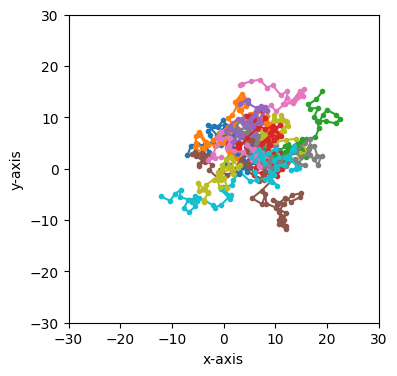

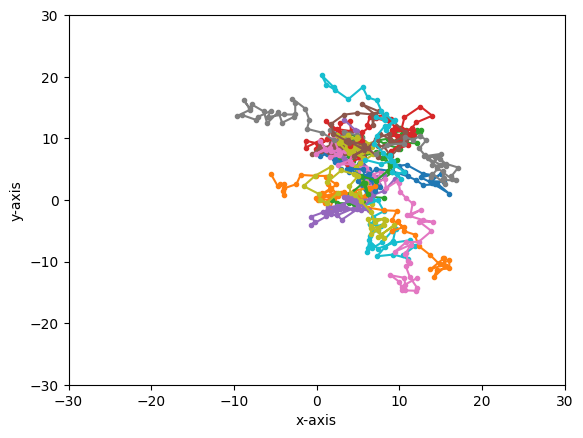

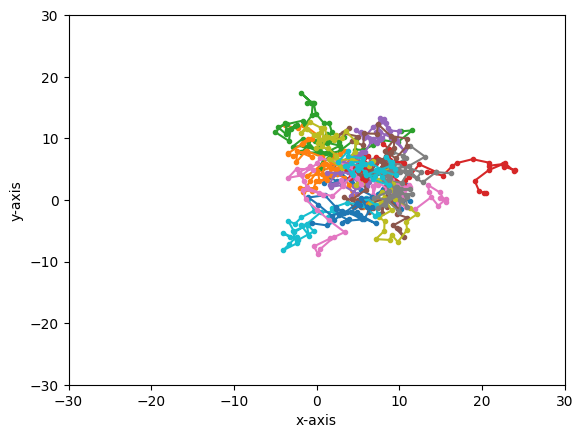

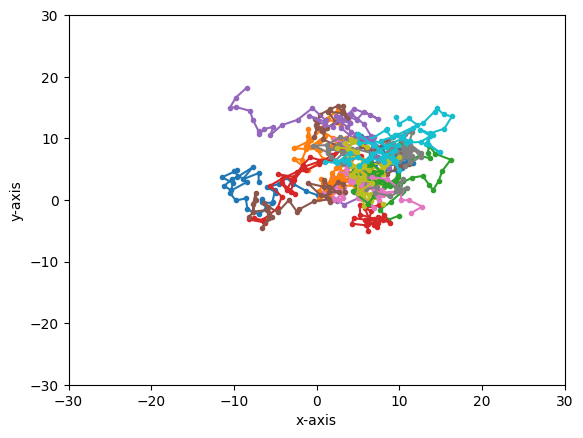

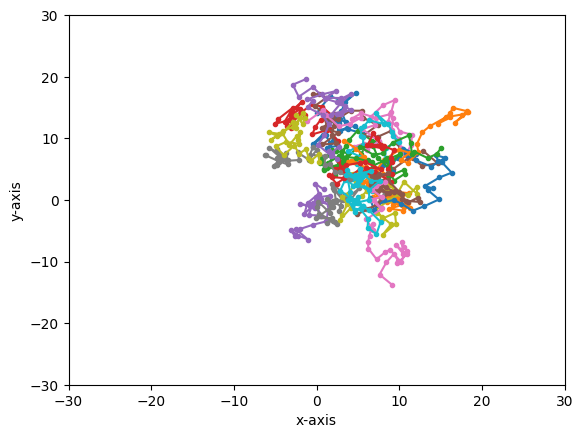

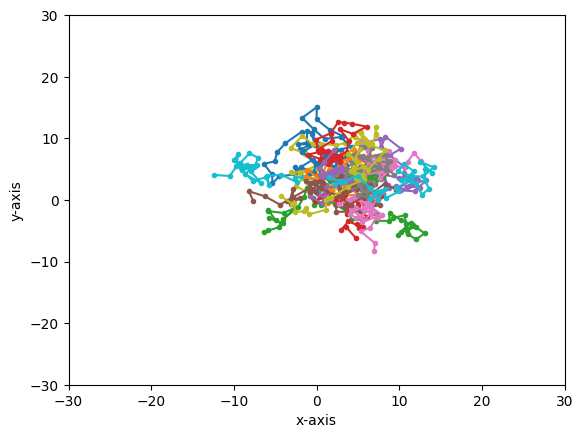

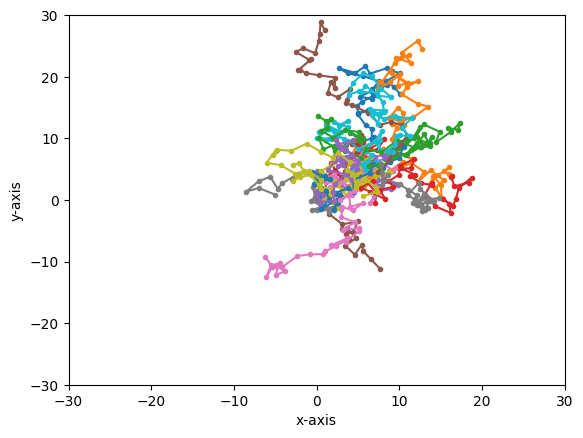

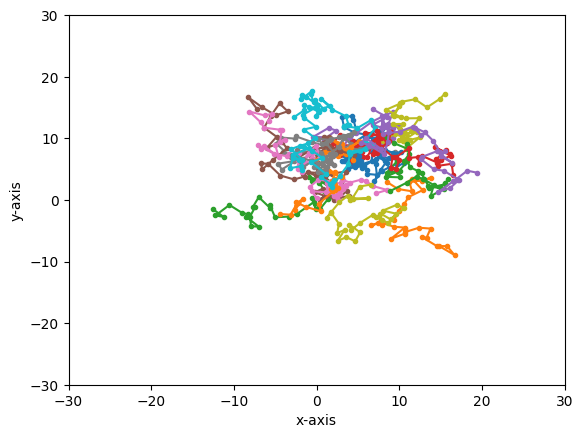

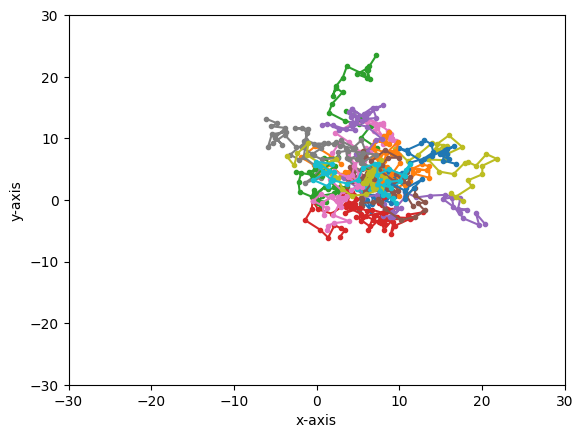

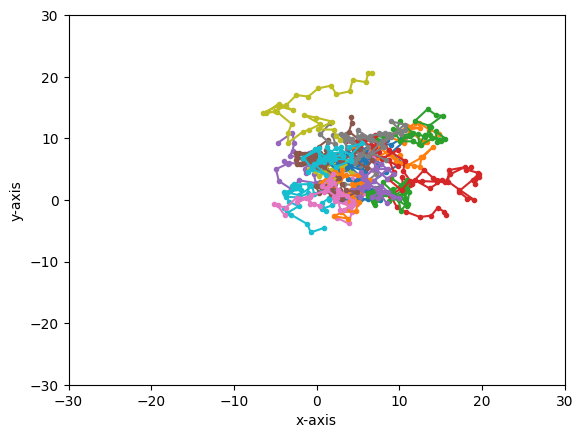

In [ ]:
import random
import matplotlib.pyplot as plt

agent_num = 20                                  # エージェント数
step = 30
                                    # 移動するステップ数

plt.figure(figsize=(4, 4))                      # matplotlib でグラフのサイズを指定する場合にはループの外で行う方が無難である（後述）

for r in range(10):

    for n in range(agent_num):
        init_location_y = random.random() * 10
        init_location_x = random.random() * 10
        location_y = init_location_y
        location_x = init_location_x
        yList = [location_y]
        xList = [location_x]

        for i in range(step):
            location_y += (random.random() - 0.5) * 4
            location_x += (random.random() - 0.5) * 4
            yList.append(location_y)
            xList.append(location_x)

    #plt.figure(figsize=(4, 4))                                    # Agent ごとのグラフを描画する場合（まとめてグラフを描画したい場合にはループの外で行う）
        plt.plot(yList, xList, marker='.')
        plt.ylim(-30, 30)                                             # ylim(最小値, 最大値)
        plt.xlim(-30, 30)                                             # xlim(最小値, 最大値)
        plt.ylabel('y-axis')
        plt.xlabel('x-axis')
    #plt.title('Agent No. {}'.format(n))                           # Agent ごとのグラフを描画する場合
    #plt.savefig('test-figure{}.png'.format(n))                    # Agent ごとのグラフを描画する場合
    plt.savefig('test-figure1.png')

    plt.show()


以下に日本語で記してください。

----

 ここから記してください。
ステップを増やすと、初期値からランダムで座標が設定されていく試行回数が増える。そうすればデータのばらつきも多くなるのでステップが増えるほどデータの分散が大きくなる。

#### 7–4–2. 面倒なことはコンピュータにやらせよう

7–4–1の試行は毎回手動で行ってきましたが、とても面倒です。何回実行したかを数えたり、結果を出力したファイルを管理しなくてはなりません。それもプログラムのなかで記述してしまったほうがよさそうです。同じパラメータ値での10回の試行を1回の実行で済むように7–4–1のコードを書き換えてください。その際、各グラフの`matplotlib.pyplot`の`title`には、Box 7を参考にして、何回目の試行であるかがわかるようにしてください。


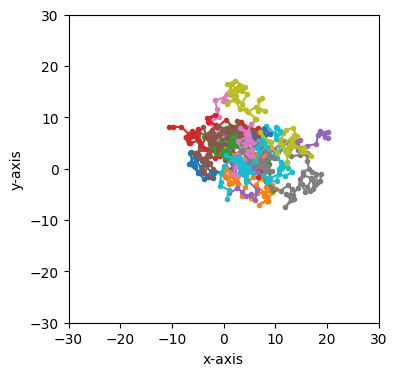

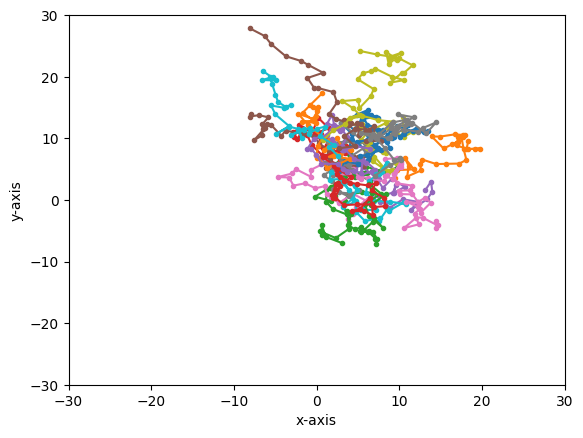

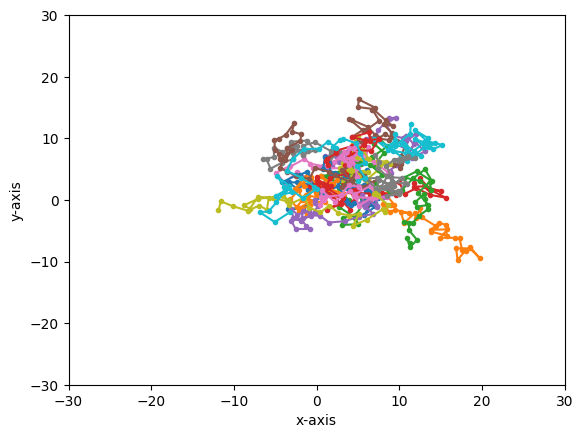

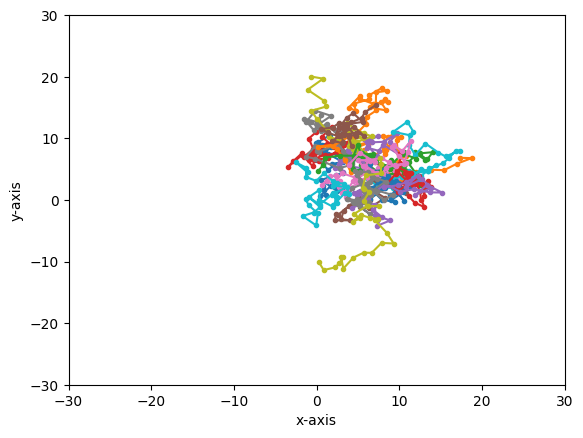

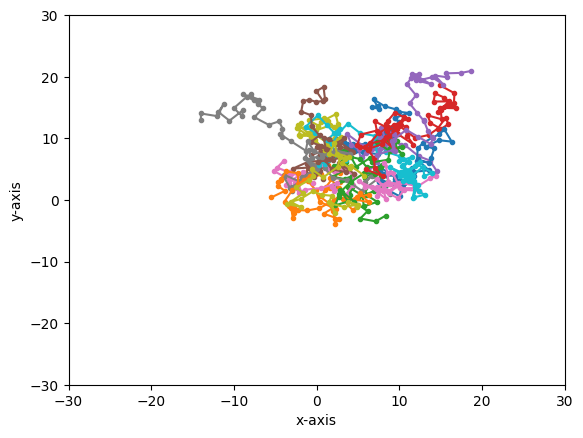

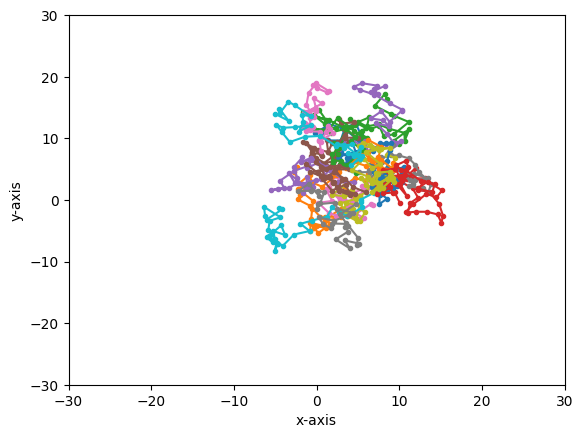

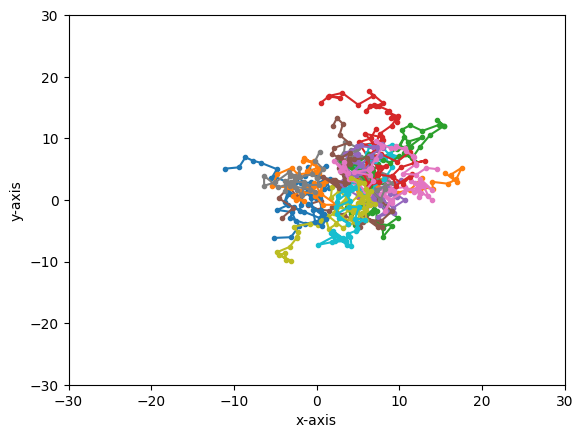

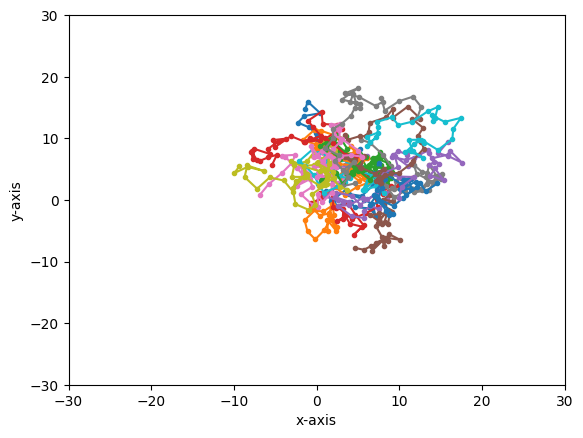

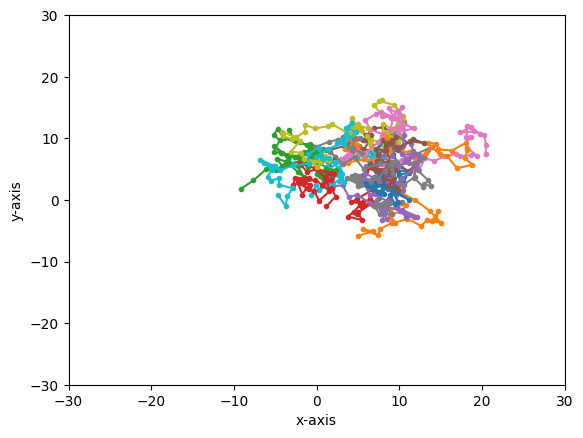

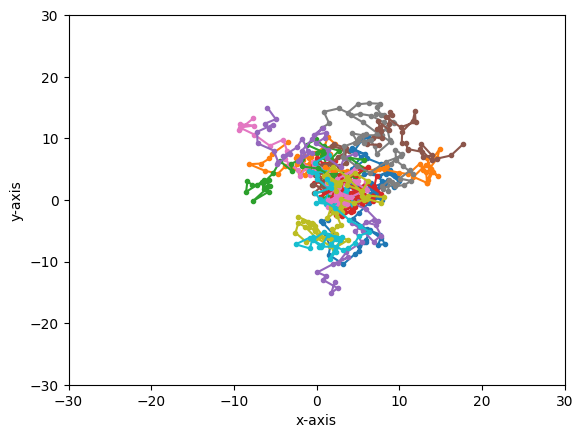

In [ ]:
# 解答を記してください。7–4–1 の解答を Copy & Paste し、5箇所追加、変更を行うのみです（どのようなループを回すかを先に考えてください）。

import random
import matplotlib.pyplot as plt

agent_num = 20                                  # エージェント数
step = 30
                                    # 移動するステップ数

plt.figure(figsize=(4, 4))                      # matplotlib でグラフのサイズを指定する場合にはループの外で行う方が無難である（後述）

for r in range(10):

    for n in range(agent_num):
        init_location_y = random.random() * 10
        init_location_x = random.random() * 10
        location_y = init_location_y
        location_x = init_location_x
        yList = [location_y]
        xList = [location_x]

        for i in range(step):
            location_y += (random.random() - 0.5) * 4
            location_x += (random.random() - 0.5) * 4
            yList.append(location_y)
            xList.append(location_x)

    #plt.figure(figsize=(4, 4))                                    # Agent ごとのグラフを描画する場合（まとめてグラフを描画したい場合にはループの外で行う）
        plt.plot(yList, xList, marker='.')
        plt.ylim(-30, 30)                                             # ylim(最小値, 最大値)
        plt.xlim(-30, 30)                                             # xlim(最小値, 最大値)
        plt.ylabel('y-axis')
        plt.xlabel('x-axis')
    #plt.title('Agent No. {}'.format(n))                           # Agent ごとのグラフを描画する場合
    plt.savefig('test-figure{}.png',format(r))                    # Agent ごとのグラフを描画する場合
    #plt.savefig('test-figure.png')

    plt.show()



保存したファイルが多くなってきました。混乱しそうです。ときどき掃除をするにはどうすればよいでしょうか？一度に10も20もできるファイルを一つずつ「削除」を選んで「OK」を押しますか？私は辛抱強くないのと間違って大切なファイルを消してしまうかもしれないので、絶対にやりません。

In [ ]:
# 解答を記してください
!

### 7–5. 演習課題: 作成した複数のプログラムを組み合わせる

第6回、第7回でつくってきたパーツの動きをよく考え、次回以降使うメタ個体群動態モデルを組み立てていきます。

-----
1.   7–3–1 のコードと7–1の初期値指定のコードをマージして、動くようにしてください。
2.   7–3–1 のコードを第6回（6–4–10）の8方向の仲間の数を数えるコードとマージして、state_number = 4 と直接指定するのではなく、そのマージしたルーチンで計算した state_number を使ってシミュレートするようにプログラムを書き換えてください。
3.   7–3–2 のコードのうち、初期分布図の部分をcsvファイルに保存し、そのファイルから読み込むようにプログラムを書き換えてください。
-----


#### 7–5–1. つくった部品を組み立てる 1

7–3–1 のコードと7–1の初期値を選択・指定するコードとをマージ（合体）して、動くようにしてください。


In [ ]:
# 解答を記してください
import random

years_considered = 20   # 初期値として与える
state_number = 4    # この値を変えながら挙動を確かめる
Pi1 = 0.15 # Pi = probability of colonization, 移入の確率 0-1
Pi2 = 0.30 # 移入・誕生の確率が大きくなるほど「仲間」は増えやすくなる。
Pi3 = 0.45
# Pe
Pe1 = 0.45 # Pe = probability of local extinction, 移出の確率 0-1
Pe2 = 0.30 # 移出・死亡（消滅）の確率が大きくなるほど「仲間」は減りやすくなる。
Pe3 = 0.20
if state_number<3:
    Pi = Pi1
    Pe = Pe1
if state_number<5:
    Pi = Pi2
    Pe = Pe2
else:

    Pi = Pi3
    Pe = Pe3

### 初期分布図（6列5行）1: 在パッチ、0: 不在パッチ               # 6-4のコードから Copy & Paste
distribution = [
                [0,0,0,0,0,0],
                [0,0,1,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]
                ]

############### 行数、列数をカウント ###############
maximum_y = len(distribution)       # 行数（第4〜5回で実習した内容）
maximum_x = len(distribution[0])    # 列数

# 変数の初期化 ###############################################
next_distribution =        [[0]*(maximum_x) for i in range(maximum_y)]                                                         # 更新用リスト（第6回の実習内容; 翌年の計算のための在・不在の分布図）
state = 0 # 個体の状態を表す変数、1は存在、0は不在を示す

# パラメータの初期値と比較して、当該年の在・不在を決定する（メイン）###      # 確率的に新しい在・不在の分布図（マップ）をつくるということ。ただし、前項のランダムウォークと違い、完全な偶然ではない（パラメータ）。
for time_year in range(years_considered):  # 今回（7–3）つくる時間規模のループ
    for y in range(maximum_y):
        for x in range(maximum_x):
            if distribution[y][x] == 1:
                Pe_rand = random.random()
                if Pe_rand < Pe:
                    state = 0
                else:
                    state = 1
            if distribution[y][x] == 0 and state_number > 0:
                Pi_rand = random.random()
                if Pi_rand < Pi:
                    state = 1
                else:
                    state = 0
            if distribution[y][x] == 0 and state_number == 0:
                state = 0
            next_distribution[y][x] = state

        # 上記の処理の結果を翌年の値として二次元リストnext_distributionに入れる

    print(next_distribution)

[[0, 1, 0, 0, 0, 1], [1, 0, 1, 1, 0, 0], [0, 0, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1], [0, 0, 0, 1, 1, 0]]
[[0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 1, 1]]
[[1, 0, 0, 1, 0, 0], [1, 1, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
[[1, 0, 1, 0, 0, 0], [1, 1, 1, 0, 0, 1], [0, 1, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 1, 0]]
[[0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1], [1, 0, 0, 1, 0, 0], [0, 1, 1, 0, 0, 0], [0, 1, 1, 0, 1, 0]]
[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0], [1, 1, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0], [0, 0, 1, 1, 1, 1]]
[[0, 1, 0, 1, 0, 0], [1, 0, 1, 0, 1, 0], [0, 1, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 0]]
[[0, 1, 0, 0, 1, 1], [1, 1, 0, 1, 0, 0], [1, 1, 0, 0, 1, 1], [0, 1, 0, 0, 1, 1], [0, 1, 0, 0, 1, 0]]
[[1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 1]]
[[1, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 1], [0, 1, 0, 0, 0, 0], [0, 0, 1, 1, 0, 1], [0, 0, 0, 

2dList5times.svg

**図. 二次元リストの表記に慣れよう**　演習課題7–5–1で求められている二次元リストが何を意味しているのかがわからないと、実行結果が期待通りに動いているかどうかの判定ができない。表記法が異なるだけで、左も右も同じ内容を示している。

#### 7–5–2. つくった部品を組み立てる 2
7–3–1 のコードを第6回（6–4–10）の8方向の仲間の数を数えるコードとマージして、state_number = 4 と直接指定するのではなく、そのマージしたコードによって取得した state_number を使ってシミュレートするようにコードを書き換えてください。

In [ ]:
# 解答を記してください
import random

years_considered = 20   # 初期値として与える
Pi = 0.3
Pe = 0.3
distribution = [
                [0,0,0,0,0,0],
                [0,0,1,0,1,0],
                [0,1,0,0,0,0],
                [0,0,0,1,0,0],
                [0,1,0,0,0,0]
                ]
maximum_y = len(distribution)       # 行数（第4〜5回で実習した内容）
maximum_x = len(distribution[0])
next_distribution =        [[0]*(maximum_x) for i in range(maximum_y)]                                                         # 更新用リスト（第6回の実習内容; 翌年の計算のための在・不在の分布図）
state = 0
for time_year in range(years_considered):
  for y in range(maximum_y):
      for x in range(maximum_x):
  #        print(y,
          state_number = 0
          for ry in range(-1,2):
              y_neighbor = y + ry        # 初期のy座標＋相対インデックス番号
              for rx in range(-1,2):
                  x_neighbor = x + rx    # 初期のx座標＋相対インデックス番号
                  if ry == 0 and rx == 0 or x_neighbor == maximum_x or y_neighbor == maximum_y:   # 判定場所（中心、自分）は除外する＋枠外を参照しないようにする（除外条件の追加）
                      pass                                                                        ## (ny, nx) = (0, 0) は自分自身のパッチ（9個のマトリックスから中心のみを除外）
                  else:
                      if distribution[y_neighbor][x_neighbor] == 1:
                          state_number += 1
                      else:
                          pass
       # print(state_number, end = '\t') # 出力結果を見やすくするため、tabで区切り、
    #print('')
 # 個体の状態を表す変数、1は存在、0は不在を示す

    # パラメータの初期値と比較して、当該年の在・不在を決定する（メイン）###      # 確率的に新しい在・不在の分布図（マップ）をつくるということ。ただし、前項のランダムウォークと違い、完全な偶然ではない（パラメータ）。
  # 今回（7–3）つくる時間規模のループ

          if distribution[y][x] == 1:
              Pe_rand = random.random()
              if Pe_rand < Pe:
                  state = 0
              else:
                  state = 1
          if distribution[y][x] == 0 and state_number > 0:
              Pi_rand = random.random()
              if Pi_rand < Pi:
                  state = 1
              else:
                  state = 0
          if distribution[y][x] == 0 and state_number == 0:
              state = 0
          next_distribution[y][x] = state

        # 上記の処理の結果を翌年の値として二次元リストnext_distributionに入れる

  for b in range(maximum_y):
      for a in range(maximum_x):
          distribution[b][a]= next_distribution[b][a]
  print(next_distribution)

[[0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 1, 0], [0, 1, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 1, 0]]
[[0, 0, 1, 1, 0, 1], [0, 1, 1, 0, 0, 1], [1, 1, 0, 0, 0, 1], [0, 0, 1, 0, 1, 1], [0, 1, 1, 0, 0, 0]]
[[0, 0, 1, 1, 0, 1], [1, 1, 1, 0, 0, 0], [1, 0, 0, 0, 0, 1], [0, 0, 1, 0, 1, 1], [0, 1, 1, 1, 1, 0]]
[[1, 0, 1, 1, 1, 1], [1, 1, 0, 0, 1, 0], [1, 0, 0, 0, 0, 1], [0, 0, 1, 1, 1, 1], [0, 1, 0, 1, 1, 1]]
[[1, 0, 1, 1, 0, 0], [1, 1, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 1, 1], [1, 1, 0, 1, 0, 1]]
[[0, 1, 1, 1, 0, 1], [0, 1, 1, 1, 1, 0], [0, 0, 1, 0, 0, 1], [0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 0, 1]]
[[0, 1, 0, 1, 0, 0], [0, 1, 0, 1, 1, 0], [0, 0, 1, 1, 1, 1], [0, 1, 1, 0, 1, 1], [1, 0, 1, 1, 1, 1]]
[[0, 1, 0, 1, 1, 1], [0, 1, 0, 1, 1, 0], [0, 1, 1, 1, 1, 1], [0, 1, 0, 1, 1, 1], [1, 0, 0, 1, 1, 0]]
[[0, 1, 0, 1, 1, 0], [0, 1, 0, 1, 1, 0], [0, 1, 1, 1, 0, 1], [0, 1, 0, 1, 1, 1], [1, 0, 0, 0, 0, 1]]
[[0, 1, 0, 0, 1, 1], [1, 1, 0, 1, 1, 0], [0, 0, 1, 1, 0, 0], [0, 1, 0, 1, 1, 1], [1, 0, 0, 

#### 7–5–3. つくった部品を組み立てる 3
7–3–2 のコードのうち、初期分布図の部分を "distribution.csv" というcsvファイルに保存（手動で行ってください）し、そのファイルから読み込むようにコードを書き換えてください。

In [ ]:
import csv
import random
file_name = 'data_data4.csv'

################ データを読み込み、リスト（l_value）に格納 #################
with open(file_name, 'r') as f:                             # 変数化する
    line = csv.reader(f, quoting = csv.QUOTE_NONNUMERIC)
    distribution  = [value for value in line]
# 解答を記してください


years_considered = 20   # 初期値として与える
Pi = 0.3
Pe = 0.3

maximum_y = len(distribution)       # 行数（第4〜5回で実習した内容）
maximum_x = len(distribution[0])
print(distribution)
next_distribution =        [[0]*(maximum_x) for i in range(maximum_y)]                                                         # 更新用リスト（第6回の実習内容; 翌年の計算のための在・不在の分布図）
state = 0
for time_year in range(years_considered):
  for y in range(maximum_y):
      for x in range(maximum_x):
  #        print(y,
          state_number = 0
          for ry in range(-1,2):
              y_neighbor = y + ry        # 初期のy座標＋相対インデックス番号
              for rx in range(-1,2):
                  x_neighbor = x + rx    # 初期のx座標＋相対インデックス番号
                  if ry == 0 and rx == 0 or x_neighbor == maximum_x or y_neighbor == maximum_y:   # 判定場所（中心、自分）は除外する＋枠外を参照しないようにする（除外条件の追加）
                      pass                                                                        ## (ny, nx) = (0, 0) は自分自身のパッチ（9個のマトリックスから中心のみを除外）
                  else:
                      if distribution[y_neighbor][x_neighbor] == 1:
                          state_number += 1
                      else:
                          pass
       # print(state_number, end = '\t') # 出力結果を見やすくするため、tabで区切り、
    #print('')
         # next_distribution =        [[0]*(maximum_x) for i in range(maximum_y)]                                                         # 更新用リスト（第6回の実習内容; 翌年の計算のための在・不在の分布図）
        #  state = 0 # 個体の状態を表す変数、1は存在、0は不在を示す
#
    # パラメータの初期値と比較して、当該年の在・不在を決定する（メイン）###      # 確率的に新しい在・不在の分布図（マップ）をつくるということ。ただし、前項のランダムウォークと違い、完全な偶然ではない（パラメータ）。
  # 今回（7–3）つくる時間規模のループ

          if distribution[y][x] == 1:
              Pe_rand = random.random()
              if Pe_rand < Pe:
                  state = 0
              else:
                  state = 1
          if distribution[y][x] == 0 and state_number > 0:
              Pi_rand = random.random()
              if Pi_rand < Pi:
                  state = 1
              else:
                  state = 0
          if distribution[y][x] == 0 and state_number == 0:
              state = 0
          next_distribution[y][x] = state

        # 上記の処理の結果を翌年の値として二次元リストnext_distributionに入れる

  for b in range(maximum_y):
        for a in range(maximum_x):
            distribution[b][a]= next_distribution[b][a]

  print(next_distribution)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[[0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
[[0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 1, 1, 1, 0], [0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 1, 1, 1], [0, 0, 1, 0, 0, 1], [0, 0, 1, 1, 0, 0], [0, 1, 1, 1, 1, 0], [0, 1, 0, 0, 0, 0]]
[[1, 0, 0, 0, 1, 0], [0, 0, 1, 0, 1, 0], [0, 0, 1, 1, 0, 0], [1, 1, 1, 0, 1, 1], [0, 0, 1, 0, 0, 0]]
[[1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 1, 1], [0, 0, 1, 1, 1, 0], [0, 1, 1, 0, 1, 0], [1, 0, 1, 0, 1, 1]]
[[1, 0, 0, 1, 0, 0], [0, 0, 0, 1, 1, 1], [1, 1, 1, 1, 1, 0], [0, 0, 1, 0, 1, 0], [1, 0, 0, 1, 1, 1]]
[[1, 1, 0, 1, 0, 0], [0, 1, 0, 1, 1, 1], [1, 0, 0, 0, 1, 0], [0, 0, 0, 0, 1, 1], [1, 0, 0, 1, 0, 1]]
[[1, 1, 0, 0, 0, 0], [1, 1, 0, 1, 1, 1], [1, 0, 1, 0, 1, 0], [1, 0, 1, 0, 1, 1], [0, 1, 1, 0, 0, 0]]
[[1, 1, 0, 1, 0, 0], [1, 1, 0, 

In [ ]:
import csv
import random
file_name = 'data_data4.csv'

################ データを読み込み、リスト（l_value）に格納 #################
with open(file_name, 'r') as f:                             # 変数化する
    line = csv.reader(f, quoting = csv.QUOTE_NONNUMERIC)
    distribution  = [value for value in line]
# 解答を記してください
years_considered = 20   # 初期値として与える
  # この値を変えながら挙動を確かめる
Pi1 = 0.15 # Pi = probability of colonization, 移入の確率 0-1
Pi2 = 0.30 # 移入・誕生の確率が大きくなるほど「仲間」は増えやすくなる。
Pi3 = 0.45
# Pe
Pe1 = 0.45 # Pe = probability of local extinction, 移出の確率 0-1
Pe2 = 0.30 # 移出・死亡（消滅）の確率が大きくなるほど「仲間」は減りやすくなる。
Pe3 = 0.20

maximum_y = len(distribution)       # 行数（第4〜5回で実習した内容）
maximum_x = len(distribution[0])
next_distribution =        [[0]*(maximum_x) for i in range(maximum_y)]                                                         # 更新用リスト（第6回の実習内容; 翌年の計算のための在・不在の分布図）
state = 0
for time_year in range(years_considered):
  for y in range(maximum_y):
      for x in range(maximum_x):
  #        print(y,
          state_number = 0
          for ry in range(-1,2):
              y_neighbor = y + ry        # 初期のy座標＋相対インデックス番号
              for rx in range(-1,2):
                  x_neighbor = x + rx    # 初期のx座標＋相対インデックス番号
                  if ry == 0 and rx == 0 or x_neighbor == maximum_x or y_neighbor == maximum_y:   # 判定場所（中心、自分）は除外する＋枠外を参照しないようにする（除外条件の追加）
                      pass                                                                        ## (ny, nx) = (0, 0) は自分自身のパッチ（9個のマトリックスから中心のみを除外）
                  else:
                      if distribution[y_neighbor][x_neighbor] == 1:
                          state_number += 1
                      else:
                          pass

          if state_number<3:
              Pi = Pi1
              Pe = Pe1
          if state_number<5:
              Pi = Pi2
              Pe = Pe2
          else:

              Pi = Pi3
              Pe = Pe3

        # print(state_number, end = '\t') # 出力結果を見やすくするため、tabで区切り、
      #print('')
  # 個体の状態を表す変数、1は存在、0は不在を示す

          if distribution[y][x] == 1:
                  Pe_rand = random.random()
          if Pe_rand < Pe:
                      state = 0
          else:
                      state = 1
          if distribution[y][x] == 0 and state_number > 0:
              Pi_rand = random.random()
              if Pi_rand < Pi:
                  state = 1
              else:
                  state = 0
          if distribution[y][x] == 0 and state_number == 0:
              state = 0
          next_distribution[y][x] = state

        # 上記の処理の結果を翌年の値として二次元リストnext_distributionに入れる

  for b in range(maximum_y):
      for a in range(maximum_x):
          distribution[b][a]= next_distribution[b][a]
  print(next_distribution)

[[0, 1, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
[[1, 1, 1, 0, 0, 0], [0, 1, 1, 0, 0, 0], [1, 0, 1, 1, 1, 0], [1, 1, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0]]
[[1, 0, 1, 0, 0, 0], [1, 0, 1, 1, 1, 0], [1, 0, 1, 0, 0, 0], [1, 1, 0, 0, 1, 0], [1, 0, 1, 0, 1, 0]]
[[0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0], [0, 1, 1, 0, 1, 0], [1, 1, 0, 0, 1, 0], [1, 0, 1, 0, 1, 1]]
[[0, 1, 0, 0, 1, 0], [0, 1, 1, 0, 1, 0], [0, 1, 1, 0, 1, 0], [1, 1, 1, 0, 1, 0], [1, 1, 0, 0, 1, 1]]
[[1, 1, 1, 0, 1, 1], [1, 1, 0, 1, 1, 0], [0, 1, 0, 0, 0, 0], [1, 1, 1, 1, 0, 0], [0, 1, 1, 0, 0, 1]]
[[1, 1, 1, 0, 1, 0], [1, 1, 0, 1, 1, 1], [0, 1, 1, 0, 0, 0], [1, 1, 1, 1, 0, 0], [0, 1, 1, 0, 0, 0]]
[[1, 1, 0, 1, 1, 1], [1, 1, 0, 1, 1, 1], [0, 1, 1, 0, 1, 0], [1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 1, 0]]
[[0, 1, 0, 1, 0, 1], [1, 0, 1, 1, 1, 1], [1, 1, 1, 0, 0, 0], [0, 0, 1, 1, 1, 0], [0, 0, 0, 1, 0, 0]]
[[1, 0, 0, 1, 1, 1], [1, 1, 1, 0, 1, 1], [0, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0], [0, 1, 0, 

#### 7–5–4. すべてのパーツを組み合わせて動くようにする

7–5–1〜7–5–3はプログラムの動作確認を簡単にするために、つくっている部品以外は固定の値を与えたり、プログラム内でデータを指定するなどしていました。ここまでの部品をすべて組み合わせてメタ個体群動態モデルのベース部分を完成させましょう。

* 初期値として移入の確率（$P_i$）と移出の確率（$P_e$）を三段階設定し、そこから選択する。
* 初期分布図は外部ファイル（distribution.csv）とし、そこから読み込んで利用する
* state_number を固定するのではなく、8方向の仲間の数をカウントする部品を使う
* 在・不在のルールに従い、確率的に当該パッチの次の時間の分布が在・不在のいずれになるかを決定する
